In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
 
import numpy as np
import matplotlib.pyplot as plt
 
import requests
import random
import gc
from zipfile import ZipFile

%matplotlib notebook

In [ ]:
train_url = 'http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt'
test_url = 'http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt'
pairs_url = 'http://vis-www.cs.umass.edu/lfw/pairs.txt'

In [ ]:
IMG_SHAPE = (250, 250, 3)

In [ ]:
def create_faces_dict(dataset):
  faces = {}

  for name, image in dataset:
    name = name.numpy().decode('utf-8')

    # image = image

    if name in faces.keys():
      faces[name].append(image)
    else:
      faces[name] = [image]

  return faces

In [ ]:
def get_items(urls, faces):
  first_face = []
  second_face = []
  labels = []
  pos = 0
  neg = 0

  for url in urls:
    data = requests.get(url).text.split('\n')

    for data_point in data:
      res = data_point.split('\t')

      if len(res) == 3:
        name = res[0]
        first_image_index, second_image_index = int(res[1]) - 1, int(res[2]) - 1

        first_face.append(faces[name][first_image_index])
        second_face.append(faces[name][second_image_index])
        labels.append(1)
        pos += 1

      elif len(res) == 4:
        first_person_name = res[0]
        first_person_index = int(res[1]) - 1
        second_person_name = res[2]
        second_person_index = int(res[3]) - 1

        first_face.append(faces[first_person_name][first_person_index])
        second_face.append(faces[second_person_name][second_person_index])
        labels.append(0)

        neg += 1
  
  print(f'pos={pos}\tneg={neg}')
  return tf.stack(first_face), tf.stack(second_face), tf.stack(labels)

  # return np.array(first_face), np.array(second_face), np.array(labels)

In [ ]:
def create_dataset(url, downloaded_data):
  faces = create_faces_dict(downloaded_data)
  first_face, second_face, labels = get_items(url, faces)
  
  dataset = tf.data.Dataset.from_tensor_slices((
      {
          'first_image': first_face, 'second_image': second_face
      }, labels
  ))

  return dataset

In [ ]:
def preprocess(images, label):
  first_image, second_image = images
  
  images[first_image] /= 255
  images[second_image] /= 255

  return images, label

In [ ]:
def show_example(index, images_list):
  fig, axs = plt.subplots(2, 1)

  axs[0].imshow(images_list[index][0])
  axs[1].imshow(images_list[index][1])

In [ ]:
# def create_network(input_shape, embedding=64, fine_tune=False):
#   base_model = keras.applications.VGG19(include_top=False, input_shape=input_shape, weights='imagenet')

#   if fine_tune:
#     base_model.trainable = False
#   else:
#     base_model.trainable = True  
#     fine_tune_at = len(base_model.layers) - int(len(base_model.layers) * 0.1)

#     for layer in base_model.layers[:fine_tune_at]:
#       layer.trainable = False
  

#   inputs = keras.Input(shape=input_shape, name='input_layer')
#   x = base_model(inputs)
#   x = layers.Conv1D(filters=256,
#                     kernel_size=1,
#                     activation='relu',
#                     kernel_regularizer='l2',
#                     name='hidden_conv_1')(x)
#   x = layers.Conv1D(filters=128, kernel_size=1,
#                     activation='relu',
#                     kernel_regularizer='l2',
#                     name='hidden_conv_2')(x)
#   x = layers.Conv1D(filters=64, kernel_size=1,
#                     activation='relu',
#                     kernel_regularizer='l2',
#                     name='hidden_conv_3')(x)
#   x = layers.Conv1D(filters=64, kernel_size=1,
#                     activation='relu',
#                     kernel_regularizer='l2',
#                     name='hidden_conv_4')(x)
#   x = layers.Conv1D(filters=64, kernel_size=1,
#                     activation='relu',
#                     kernel_regularizer='l2',
#                     name='hidden_conv_5')(x)
#   # x = layers.Conv2D(filters=128, kernel_size=7, activation='relu', name='hidden_conv_3')(x)
#   x = layers.Flatten(name='Flatten')(x)
#   # x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
#   x = layers.Dense(64, activation='relu',
#                    kernel_regularizer='l2',
#                    kernel_initializer=keras.initializers.HeNormal(),
#                    name='hidden_layer_1')(x)
#   outputs = layers.Dense(embedding,
#                         #  kernel_initializer=keras.initializers.HeNormal(),
#                         #  kernel_regularizer='l2',
#                          name='embedding_layer')(x)

#   model = keras.Model(inputs, outputs)

#   model.summary()

#   return model
# 30 ep --> 82 %

In [ ]:
def create_network(input_shape, embedding=64, fine_tune=False):
  base_model = keras.applications.VGG19(include_top=False, input_shape=input_shape, weights='imagenet')

  if fine_tune:
    base_model.trainable = False
  else:
    base_model.trainable = True  
    fine_tune_at = len(base_model.layers) - int(len(base_model.layers) * 0.1)

    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
  

  inputs = keras.Input(shape=input_shape, name='input_layer')
  x = base_model(inputs)
  x = layers.Conv1D(filters=256,
                    kernel_size=1,
                    activation='relu',
                    kernel_regularizer='l2',
                    name='hidden_conv_1')(x)
  x = layers.Conv1D(filters=128, kernel_size=1,
                    activation='relu',
                    kernel_regularizer='l2',
                    name='hidden_conv_2')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv1D(filters=64, kernel_size=1,
                    activation='relu',
                    kernel_regularizer='l2',
                    name='hidden_conv_3')(x)
  x = layers.Conv1D(filters=64, kernel_size=1,
                    activation='relu',
                    kernel_regularizer='l2',
                    name='hidden_conv_4')(x)
  x = layers.Conv1D(filters=64, kernel_size=1,
                    activation='relu',
                    kernel_regularizer='l2',
                    name='hidden_conv_5')(x)
  x = layers.BatchNormalization()(x)
  # x = layers.Conv2D(filters=128, kernel_size=7, activation='relu', name='hidden_conv_3')(x)
  x = layers.Flatten(name='Flatten')(x)
  # x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
  x = layers.Dense(64, activation='relu',
                   kernel_regularizer='l2',
                   kernel_initializer=keras.initializers.HeNormal(),
                   name='hidden_layer_1')(x)
  outputs = layers.Dense(embedding,
                        #  kernel_initializer=keras.initializers.HeNormal(),
                        #  kernel_regularizer='l2',
                         name='embedding_layer')(x)

  model = keras.Model(inputs, outputs)

  model.summary()

  return model

In [ ]:
# def create_network(input_shape, embedding=64, fine_tune=False):
#   input = keras.Input(input_shape, name='feature_extractor_input')

#   x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
#                     name='conv_1_1', kernel_initializer=keras.initializers.HeUniform(), kernel_regularizer='l2')(input)
#   x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
#                     name='conv_1_2', kernel_initializer=keras.initializers.HeUniform(), kernel_regularizer='l2')(x)
#   x = layers.MaxPool2D(4, name='max_poolinh_1')(x)
#   x = layers.BatchNormalization(name='batch_normalizer_1')(x)

#   x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
#                     name='conv_2_1', kernel_initializer=keras.initializers.HeUniform(), kernel_regularizer='l2')(x)
#   x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
#                     name='conv_2_2', kernel_initializer=keras.initializers.HeUniform(), kernel_regularizer='l2')(x)
#   x = layers.MaxPool2D(4, name='max_poolinh_2')(x)
#   x = layers.BatchNormalization(name='batch_normalizer_2')(x)

#   x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',
#                     name='conv_3_1', kernel_initializer=keras.initializers.HeUniform(), kernel_regularizer='l2')(x)
#   x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',
#                     name='conv_3_2', kernel_initializer=keras.initializers.HeUniform(), kernel_regularizer='l2')(x)
#   x = layers.MaxPool2D(2, name='max_poolinh_3')(x)
#   x = layers.BatchNormalization(name='batch_normalizer_3')(x)

#   x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
#                     name='conv_4_1', kernel_initializer=keras.initializers.HeUniform(), kernel_regularizer='l2')(x)
#   x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
#                     name='conv_4_2', kernel_initializer=keras.initializers.HeUniform(), kernel_regularizer='l2')(x)
#   x = layers.MaxPool2D(2, name='max_poolinh_4')(x)
#   x = layers.BatchNormalization(name='batch_normalizer_4')(x)

#   # x = layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv_5_1')(x)
#   # x = layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv_5_2')(x)
#   # x = layers.MaxPool2D(2, name='max_poolinh_5')(x)
#   # x = layers.BatchNormalization(name='batch_normalizer_5')(x)

#   x = layers.Flatten(name='flatten')(x)

#   x = layers.Dense(128, activation='relu', kernel_regularizer='l2',  name='dense_1', kernel_initializer=keras.initializers.HeUniform())(x)
#   x = layers.Dense(128, activation='relu', kernel_regularizer='l2', name='dense_2', kernel_initializer=keras.initializers.HeUniform())(x)
#   output = layers.Dense(embedding , name='embedding', kernel_initializer=keras.initializers.HeUniform ())(x)

#   model = keras.Model(inputs=input, outputs=output)

#   return model

In [ ]:
def euclidean_distance(vectors):
  first_embedding, second_embedding = vectors

  sum_squared = K.sum(K.square(first_embedding - second_embedding),
      axis=1,
      keepdims=True
  )

  return K.maximum(sum_squared, K.epsilon())

In [ ]:
def contrastive_loss(margin=1):
  def loss_function(y, preds):
    y = tf.cast(y, preds.dtype)

    squared_preds = K.square(preds)
    squared_margin = K.square(K.maximum(margin - preds, 0))

    loss = K.mean(y * squared_preds + (1 - y) * squared_margin)

    return loss
  return loss_function

In [ ]:
def plot_hostory(history):
  plt.plot(history.history['loss'], color='blue', label='train_loss')
  plt.plot(history.history['val_loss'], color='red', label='val_loss')
  plt.legend()

In [ ]:
def test_model_accuracy(model, data, epsilon):
  total_count = 0
  true_predictions = 0

  for faces, labels in data:
    first_face, second_face = faces
    labels = labels.numpy()

    count = faces[first_face].shape[0]
    total_count += count

    first_face_embedding = model(faces[first_face])
    second_face_embedding = model(faces[second_face])
    
    temp = euclidean_distance((first_face_embedding, second_face_embedding)).numpy().reshape(-1)
    true_predicted_labels = (temp <= epsilon) == labels

    # print('------------------------------------------------------------------------------')
    # print(temp, labels, true_predicted_labels ,sep='\n')

    true_predictions += true_predicted_labels.sum()

  return true_predictions / total_count

In [ ]:
def error_analysis(model, data, epsilon):
  wrong_classified = []

  for faces, labels in data:
    first_face, second_face = faces
    labels = labels.numpy()

    # first_face, second_face = np.array(first_face), np.array(second_face)

    first_face_embedding = model(faces[first_face])
    second_face_embedding = model(faces[second_face])
    
    temp = euclidean_distance((first_face_embedding, second_face_embedding)).numpy().reshape(-1)
    true_predicted_labels = (temp <= epsilon) == labels

    for index, label in enumerate(true_predicted_labels):
      if not label:
          wrong_classified.append(
              [faces[first_face][index, :, :, :],
              faces[second_face][index, :, :, :]]
          )

  return wrong_classified

In [ ]:
class MyCustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('Garbages collected')
    gc.collect()

In [ ]:
first_image = keras.Input(shape=IMG_SHAPE, name='first_image')
second_image = keras.Input(shape=IMG_SHAPE, name='second_image')

feature_extractor = create_network(IMG_SHAPE, 64, True)

first_embedding = feature_extractor(first_image)
second_embedding = feature_extractor(second_image)

output_layer = layers.Lambda(euclidean_distance)([first_embedding, second_embedding])

# output_layer = layers.Dense(1, activation='sigmoid', name='output_layer')(distance)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 250, 250, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
hidden_conv_1 (Conv1D)       (None, 7, 7, 256)         131328    
_________________________________________________________________
hidden_conv_2 (Conv1D)       (None, 7, 7, 128)         32896     
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
hidden_conv_3 (Conv1D)       (None, 7, 7, 64)          8256      
_________________________________________________________________
hidden_conv_4 (Conv1D)       (None, 7, 7, 64)          4160  

In [ ]:
feature_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 250, 250, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
hidden_conv_1 (Conv1D)       (None, 7, 7, 256)         131328    
_________________________________________________________________
hidden_conv_2 (Conv1D)       (None, 7, 7, 128)         32896     
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
hidden_conv_3 (Conv1D)       (None, 7, 7, 64)          8256      
_________________________________________________________________
hidden_conv_4 (Conv1D)       (None, 7, 7, 64)          4160  

In [ ]:
model = keras.Model(inputs=[first_image, second_image], outputs=output_layer, name='model')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first_image (InputLayer)        [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
second_image (InputLayer)       [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 64)           20410880    first_image[0][0]                
                                                                 second_image[0][0]               
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                  

In [ ]:
model.compile(
    loss=contrastive_loss(5),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [ ]:
data = tfds.load(name='lfw', as_supervised=True)['train']

In [ ]:
train_data = create_dataset([train_url, pairs_url], data)
test_data = create_dataset([test_url], data)
# pairs = create_dataset(pairs_url, data)

pos=4100	neg=4100
pos=500	neg=500


In [ ]:
train_data = train_data.shuffle(2048).batch(8)
test_data = test_data.shuffle(2048).batch(8)

validation_data = test_data.take(len(test_data) // 2)
test_data = test_data.skip(len(test_data) // 2)

In [ ]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10,
    callbacks=[MyCustomCallback()]
)

Epoch 1/10
1025/1025 [==============================] - 361s 334ms/step - loss: 30.8891 - val_loss: 17.4949
Garbages collected
Epoch 2/10
1025/1025 [==============================] - 347s 338ms/step - loss: 16.2284 - val_loss: 16.5827
Garbages collected
Epoch 3/10
1025/1025 [==============================] - 348s 339ms/step - loss: 15.5804 - val_loss: 15.7842
Garbages collected
Epoch 4/10
1025/1025 [==============================] - 347s 338ms/step - loss: 15.3365 - val_loss: 16.5479
Garbages collected
Epoch 5/10
1025/1025 [==============================] - 348s 339ms/step - loss: 13.8424 - val_loss: 15.1502
Garbages collected
Epoch 6/10
1025/1025 [==============================] - 340s 331ms/step - loss: 13.6532 - val_loss: 15.0067
Garbages collected
Epoch 7/10
1025/1025 [==============================] - 342s 333ms/step - loss: 14.6229 - val_loss: 15.4980
Garbages collected
Epoch 8/10
1025/1025 [==============================] - 352s 343ms/step - loss: 15.7806 - val_loss: 14.8415
Gar

In [ ]:
model.evaluate(test_data)

63/63 [==============================] - 20s 309ms/step - loss: 11.8565


11.856489181518555

In [ ]:
feature_extractor.trainable = False
print(f'accuracy = {test_model_accuracy(feature_extractor, test_data, 3) * 100}%')

# VGG19:
# margin = 0.5 --> accuracy = 49.0 %
# margin = 1   --> accuracy = 50.8 %

# my network:
# margin = 10  --> accuracy = 49.0 %
# margin = 1   --> accuracy = 57.4 %
# margin = 0.5 --> accuracy = 51.0 %

# my_network (regularizrd):
# margin = 0.5 --> accuracy = 52.8 %
# margin = 2   --> accuracy = 62.6 %
# margin = 1   --> accuracy = 61.6 %

# shallower_network (regularized):
# margin = 1   --> accuracy = 56.0 %

# deeper_network (regularized):
# margin = 1   --> accuracy = 51.8 %

# he (Normal) + regularizer:
# margin = 2   --> accuracy = 50.2 %
# margin = 1   --> accuracy = 54.2 %

# he (Uniform) + regularizer:
# margin = 1   --> accuracy = 54.8 %
# margin = 5 (epsilon = 3) --> accuracy = 82%

accuracy = 69.24603174603175%


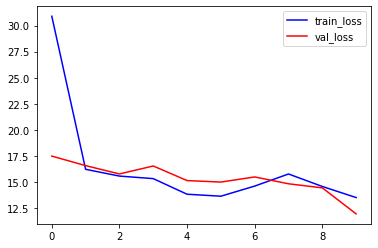

In [ ]:
plot_hostory(history)

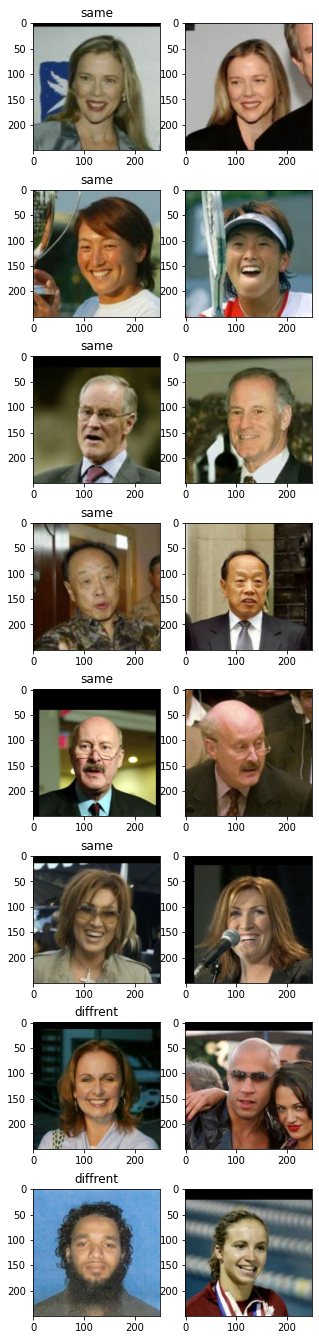

In [ ]:
batch = train_data.skip(8).take(1)

for faces, labels in batch:
  first_face, second_face = faces
  
  count = faces[first_face].shape[0]
  
  fig, axs = plt.subplots(count, 2)

  for i in range(count):
    axs[i, 0].imshow(faces[first_face][i])
    axs[i, 1].imshow(faces[second_face][i])
    axs[i, 0].set_title('same' if labels[i] == 1 else 'diffrent')


  fig.set_size_inches(5, count*3)

In [ ]:
wrongs = error_analysis(feature_extractor, test_data, 3)

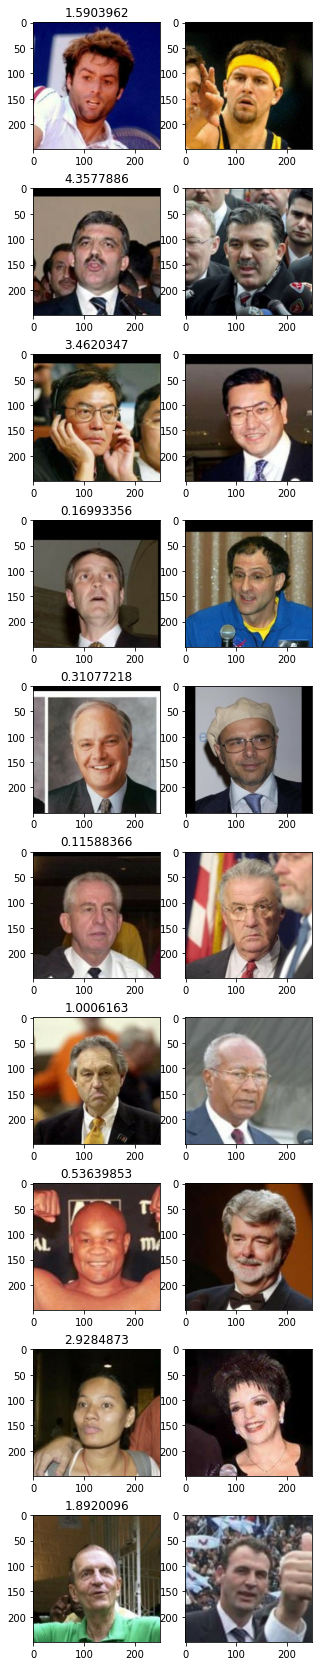

In [ ]:
count = 10
  
fig, axs = plt.subplots(count, 2)

for i in range(count):
  axs[i, 0].imshow(wrongs[i][0])
  axs[i, 1].imshow(wrongs[i][1])


  inputs = tf.stack([
      wrongs[i][0],
      wrongs[i][1],
      ])
  
  embeddings = feature_extractor(inputs)
  label = K.sum(tf.square(embeddings[0, :] -  embeddings[1, :])).numpy()
  axs[i, 0].set_title(label)


fig.set_size_inches(5, count*3)

In [ ]:
# for index in range(10):

#   inputs = tf.stack(
#       [
#       wrongs[index][0],
#       wrongs[index][1],
#       ]
#   )
#   embeddings = feature_extractor(inputs)

#   s = K.sum(tf.square(tf.abs(embeddings[0, :] -  embeddings[1, :])))

#   print(s)

In [ ]:
model.save('model.h5')